# SUMMARY CHAPTER 2

## IMPORT LIBRARY

In [1]:
from PIL import Image
from skimage.io import imread, imshow, show
from scipy import ndimage, misc, signal, stats
# from scipy.stats import signaltonoise
# signaltonoise no longer available
# https://docs.scipy.org/doc/scipy/release.0.16.0.html?highlight=signaltonoise#deprecated-features
from skimage import data, img_as_float
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import rescale
import matplotlib.pylab as plt
import numpy as np
import numpy.fft as fp
import timeit

In [2]:
# Source: https://github.com/scipy/scipy/blob/v0.16.0/scipy/stats/stats.py#L1963
def signaltonoise(a, axis=0, ddof=0):
    """
    The signal-to-noise ratio of the input data.
    Returns the signal-to-noise ratio of `a`, here defined as the mean
    divided by the standard deviation.
    Parameters
    ----------
    a : array_like
        An array_like object containing the sample data.
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    ddof : int, optional
        Degrees of freedom correction for standard deviation. Default is 0.
    Returns
    -------
    s2n : ndarray
        The mean to standard deviation ratio(s) along `axis`, or 0 where the
        standard deviation is 0.
    """
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def readAsGray(path: str) -> np.ndarray:
    _im = imread(path)
    if len(_im.shape) == 2:
        return _im
    _im = rgba2rgb(_im) if _im.shape[2] > 3 else _im
    _im = rgb2gray(_im)
    return _im

## SAMPLING

### UP SAMPLING

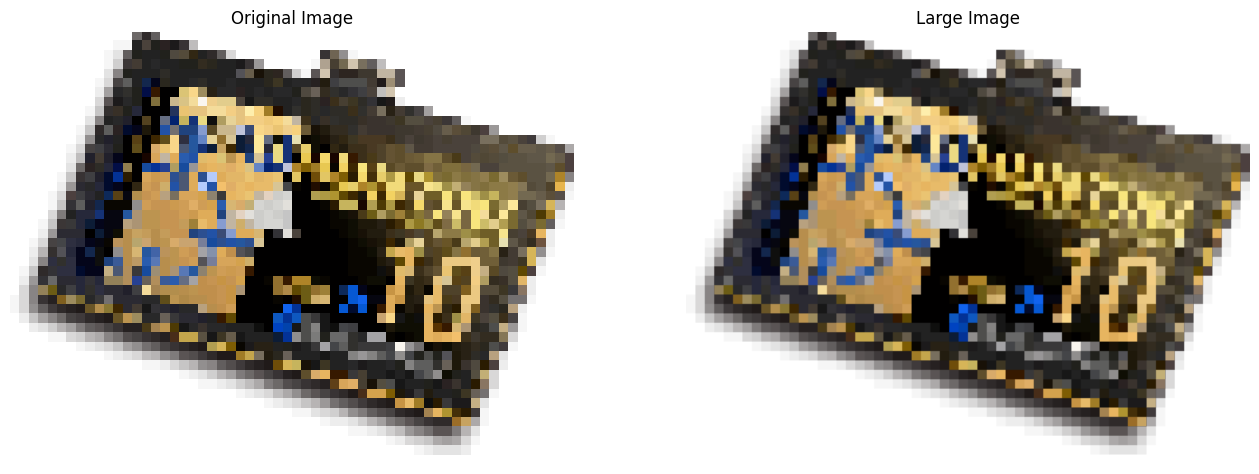

In [3]:
im = Image.open("../images/Headhunt10_small.png")
resample = Image.Resampling.BICUBIC
scale = 5
im_large = im.resize((im.width*scale, im.height*scale), resample)

plt.figure(figsize=(16,8))
plt.subplot(121), plt.imshow(im), plt.axis(False), plt.title("Original Image")
plt.subplot(122), plt.imshow(im_large), plt.axis(False), plt.title("Large Image")
plt.show()

### DOWN SAMPLING

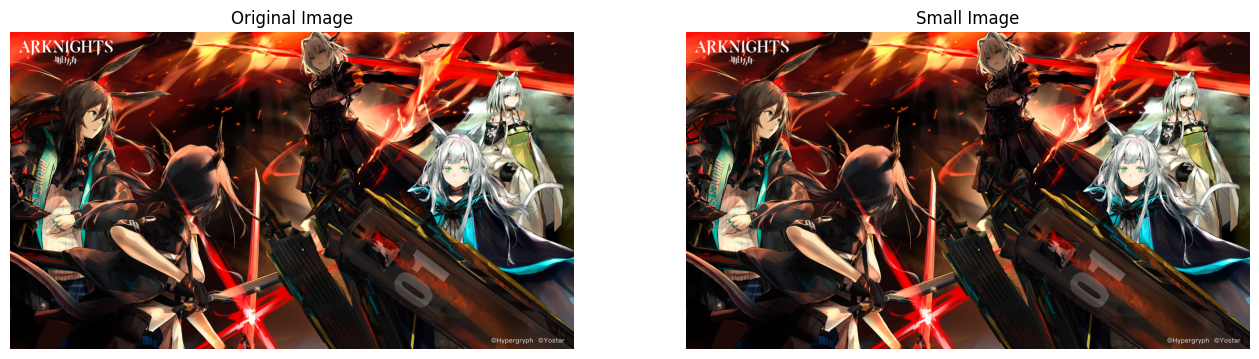

In [4]:
im = Image.open("../images/arknightsc8.jpg")
resample = Image.Resampling.LANCZOS
scale = 5
im_large = im.resize((im.width//scale, im.height//scale), resample)

plt.figure(figsize=(16,8))
plt.subplot(121), plt.imshow(im), plt.axis(False), plt.title("Original Image")
plt.subplot(122), plt.imshow(im_large), plt.axis(False), plt.title("Small Image")
plt.show()

## QUANTIZATION

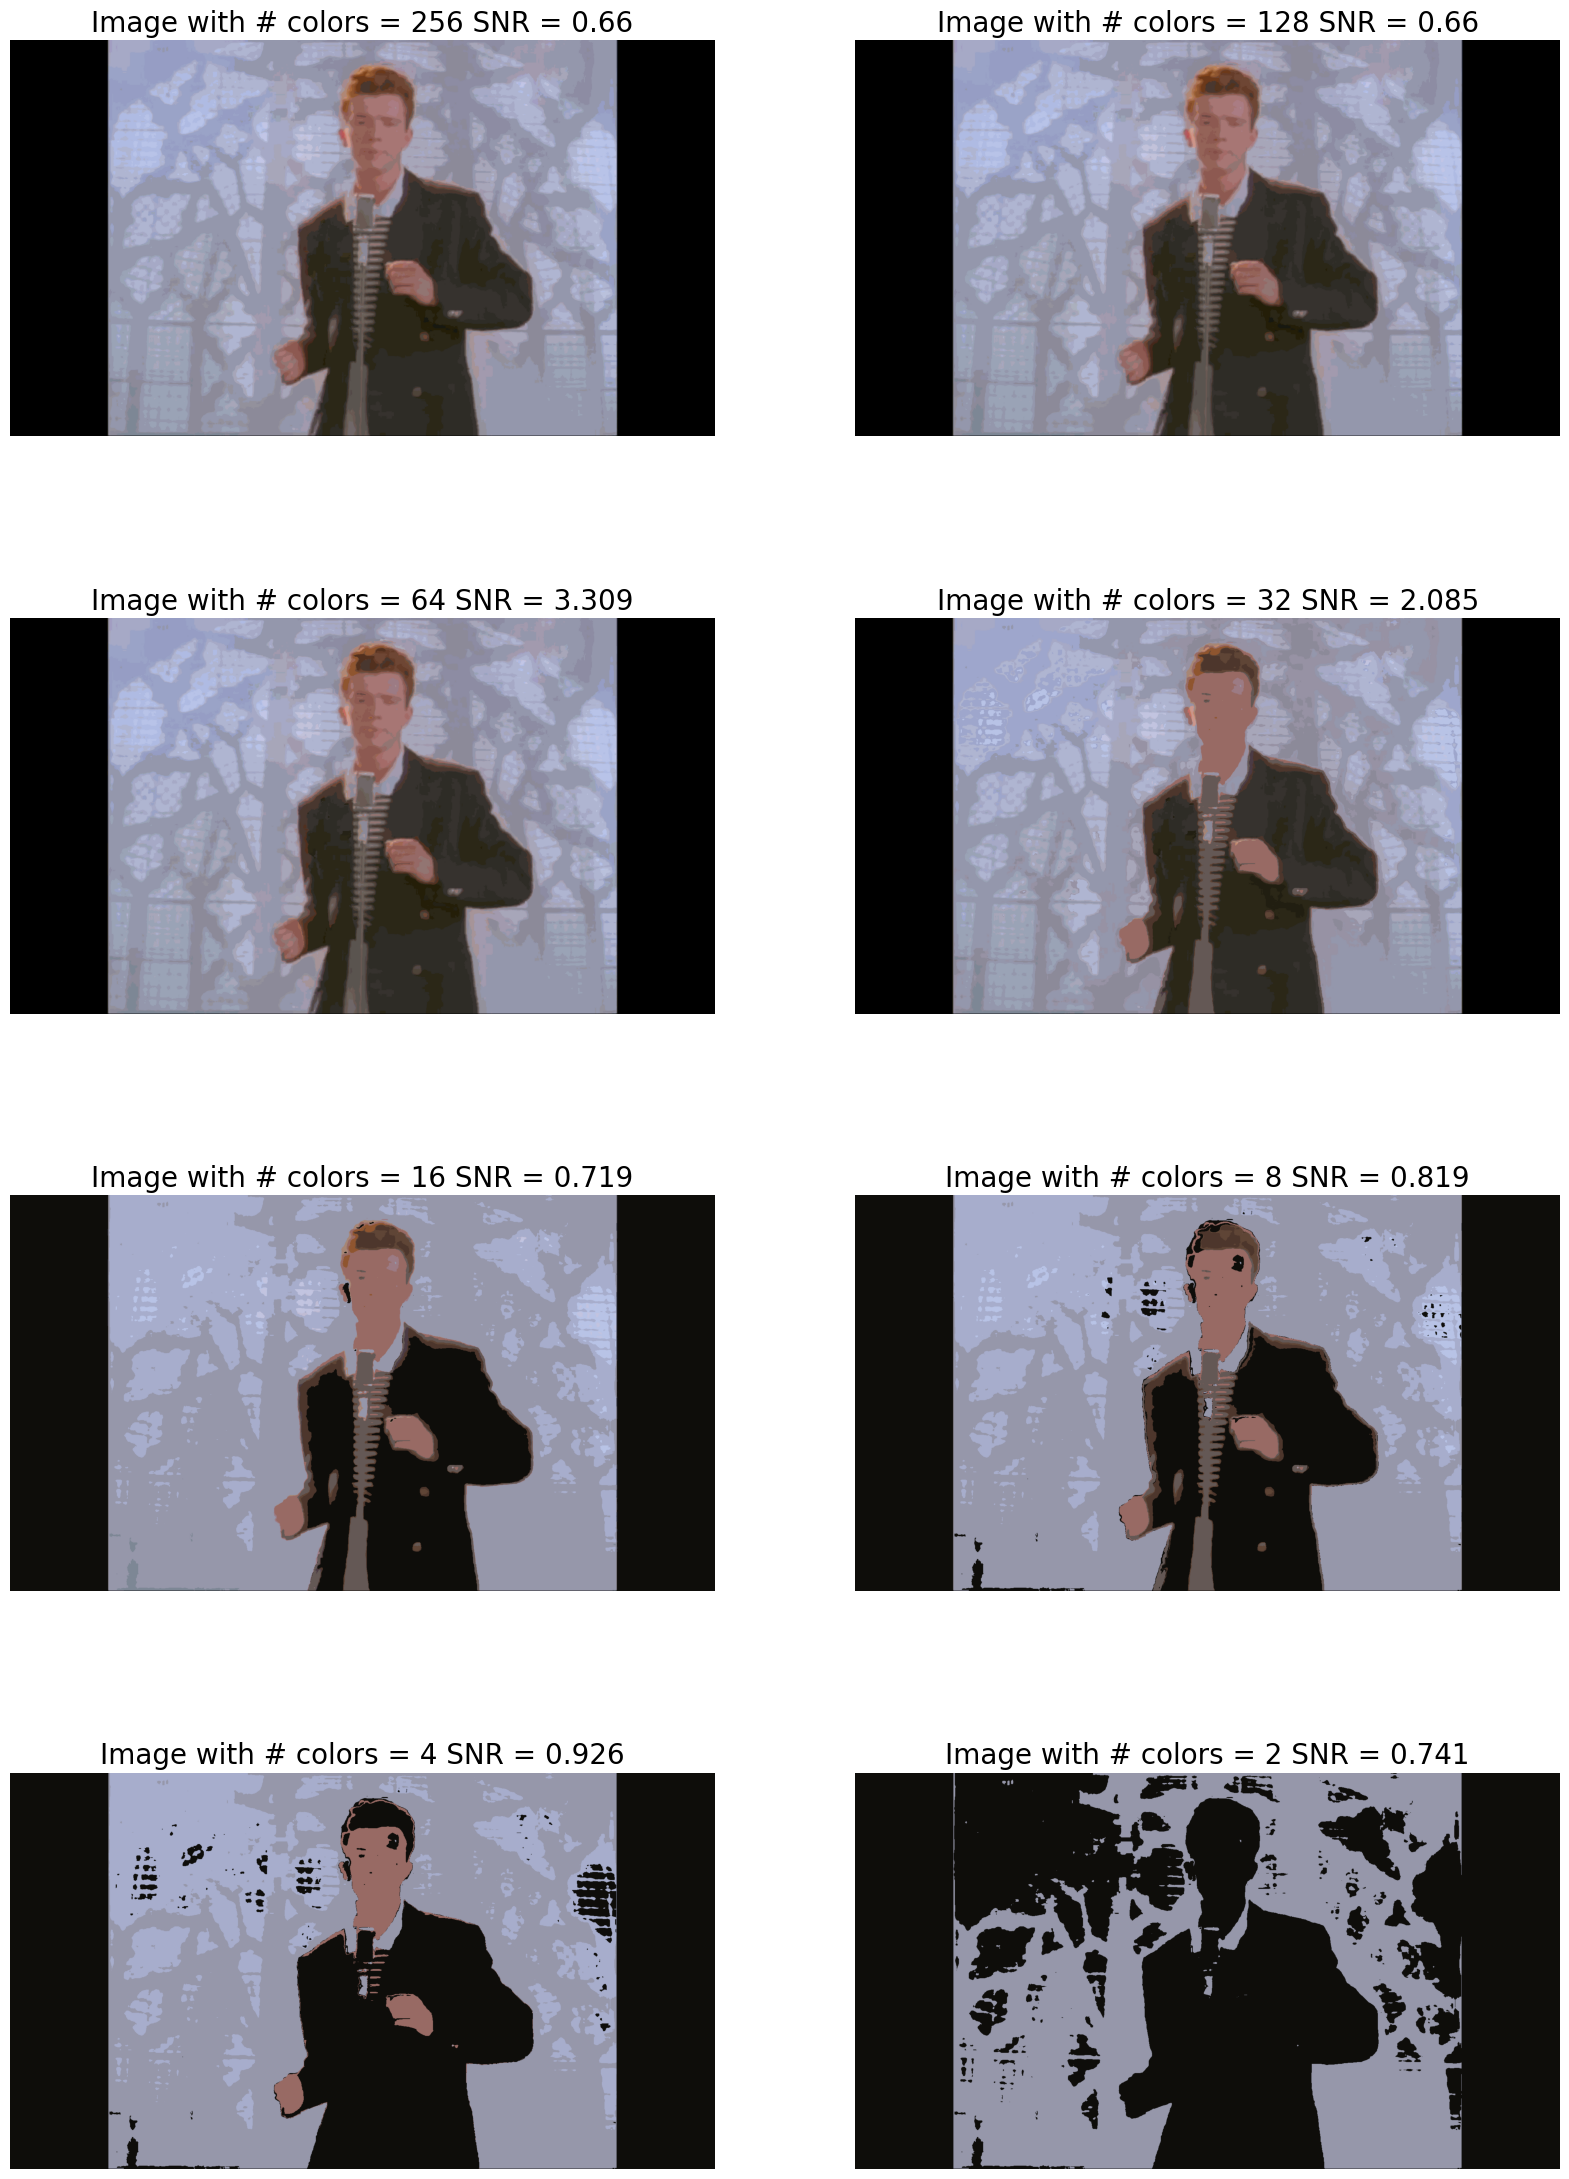

In [5]:
im = Image.open('../images/rick2.png')
plt.figure(figsize=(20,30))
num_colors_list = [1 << n for n in range(8,0,-1)]
snr_list = []
i = 1
for num_colors in num_colors_list:
    im1 = im.convert('P', palette=Image.Palette.ADAPTIVE, colors=num_colors)
    plt.subplot(4,2,i), plt.imshow(im1), plt.axis('off')
    snr_list.append(signaltonoise(im1, axis=None))
    plt.title('Image with # colors = ' + str(num_colors) + ' SNR = ' + str(np.round(snr_list[i-1],3)), size=20)
    i += 1
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()


## DISCRETE FOURIER TRANSFORM

### FFT AND IFFT

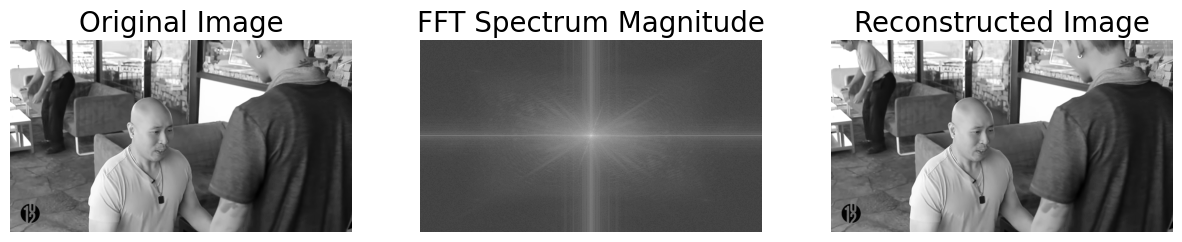

In [6]:
im = readAsGray('../images/makepeace.png')

# fourier transform
freq = fp.fft2(im)

# inverse fourier transform
im1 = fp.ifft2(freq).real

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Original Image', size=20), plt.axis(False)
plt.subplot(132), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(freq))), cmap='gray')
plt.title('FFT Spectrum Magnitude', size=20), plt.axis(False)
plt.subplot(133), plt.imshow(np.clip(im1,0,255), cmap='gray'), plt.title('Reconstructed Image', size=20), plt.axis(False)
plt.show()

### CONSTRUCT IMAGE FROM 2 IMAGES

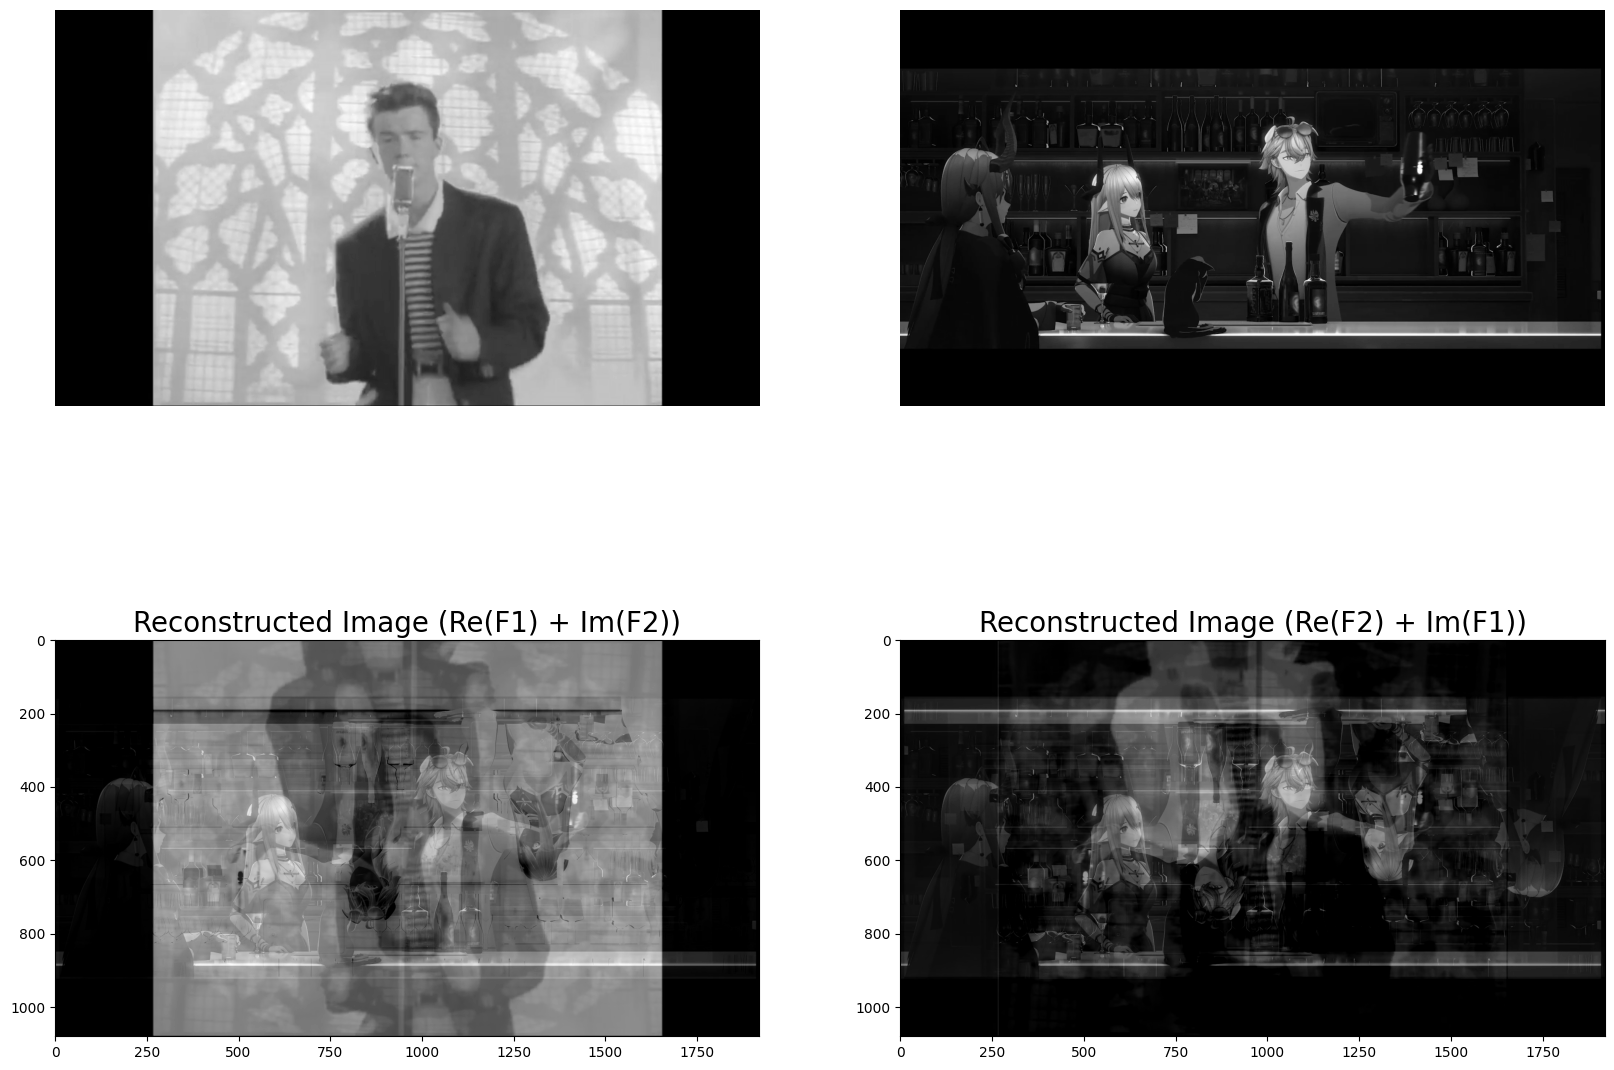

In [7]:
im1 = readAsGray("../images/rick1.png")
im2 = readAsGray("../images/agent1.png")
freq1 = fp.fft2(im1)
freq2 = fp.fft2(im2)

plt.figure(figsize=(20,15)), plt.gray()
plt.subplot(221), plt.imshow(im1), plt.axis(False)
plt.subplot(222), plt.imshow(im2), plt.axis(False)

im1_ = fp.ifft2(np.vectorize(complex)(freq1.real, freq2.imag)).real
im2_ = fp.ifft2(np.vectorize(complex)(freq2.real, freq1.imag)).real
plt.subplot(223), plt.imshow(np.clip(im1_,0,255), cmap='gray')
plt.title('Reconstructed Image (Re(F1) + Im(F2))', size=20)
plt.subplot(224), plt.imshow(np.clip(im2_,0,255), cmap='gray')
plt.title('Reconstructed Image (Re(F2) + Im(F1))', size=20)
plt.show()

## CONVOLUTION

### GRAYSCALE IMAGE

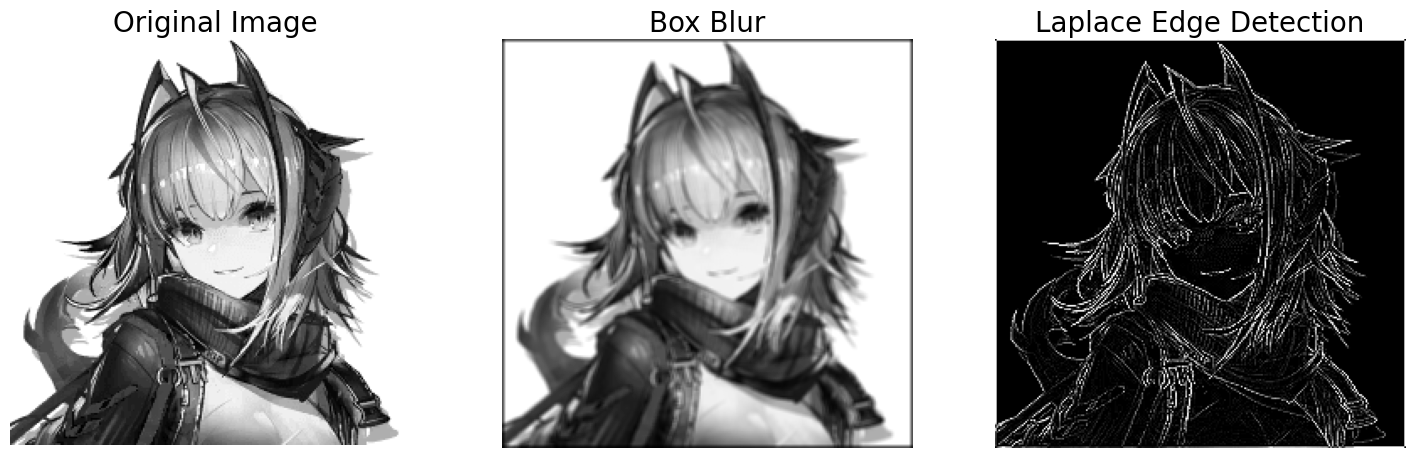

In [8]:
im = readAsGray("../images/w.png").astype(float)

blur_box_kernel = np.ones((3,3)) / 9
edge_laplace_kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
# edge_laplace_kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])

im_blurred = signal.convolve2d(im, blur_box_kernel)
im_edges = np.clip(signal.convolve2d(im, edge_laplace_kernel), 0, 1)
# im_edges = signal.convolve2d(im, edge_laplace_kernel)

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(18, 6))
axes[0].imshow(im, cmap=plt.cm.gray)
axes[0].set_title('Original Image', size=20)
axes[1].imshow(im_blurred, cmap=plt.cm.gray)
axes[1].set_title('Box Blur', size=20)
axes[2].imshow(im_edges, cmap=plt.cm.gray)
axes[2].set_title('Laplace Edge Detection', size=20)
for ax in axes:
    ax.axis('off')
plt.show()

### RGB IMAGE

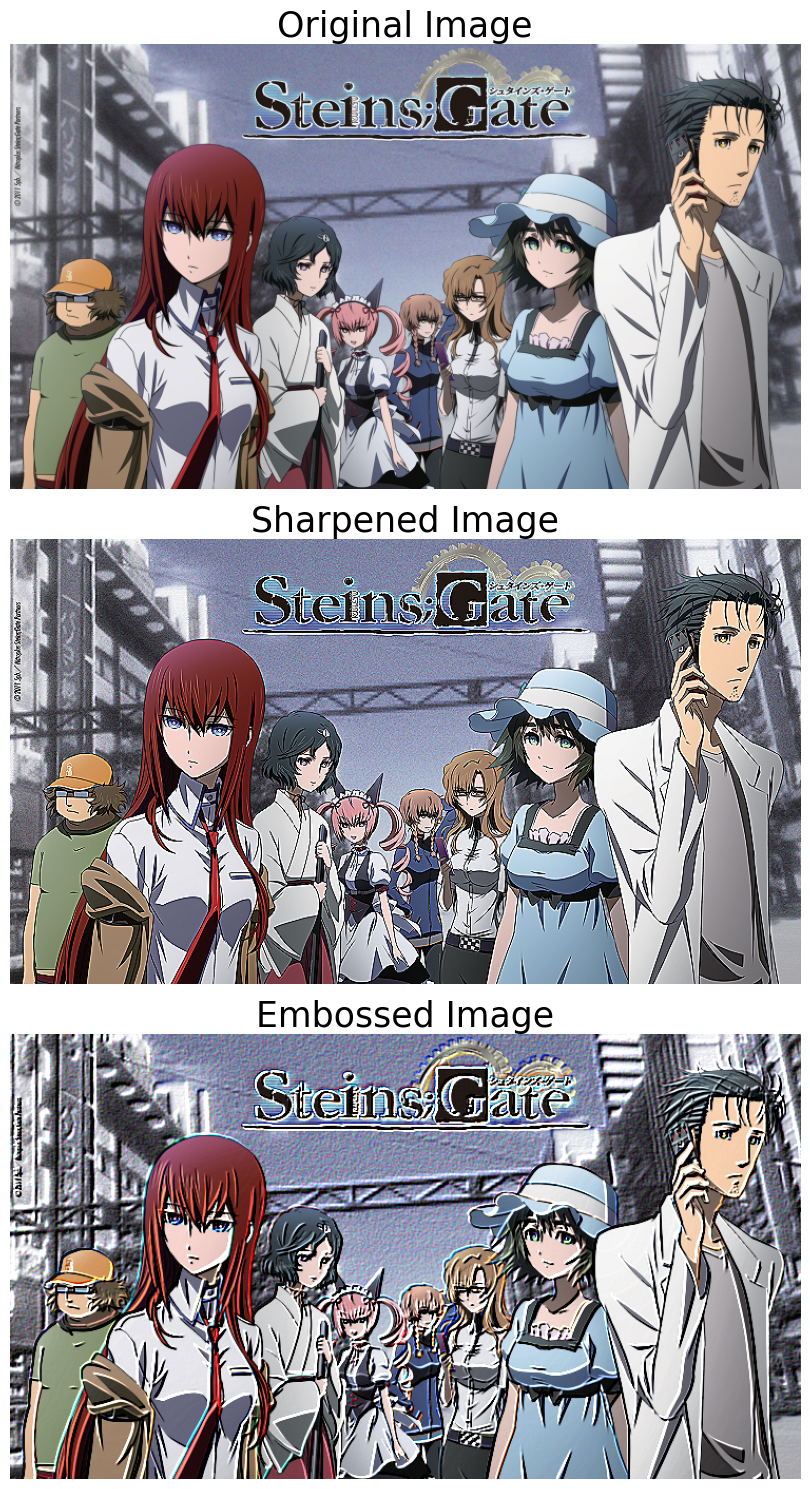

In [9]:
im = imread('../images/steinsgate.png').astype(float)
sharpen_kernel = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0]).reshape((3, 3,1))
emboss_kernel = np.array(np.array([[-2,-1,0],[-1,1,1],[0,1,2]])).reshape((3, 3, 1))

im_sharp = ndimage.convolve(im, sharpen_kernel, mode='nearest')
im_sharp = np.clip(im_sharp, 0, 255).astype(np.uint8)
im_emboss = ndimage.convolve(im, emboss_kernel, mode='nearest')
im_emboss = np.clip(im_emboss, 0, 255).astype(np.uint8)

plt.figure(figsize=(10,15))
plt.subplot(311), plt.imshow(im.astype(np.uint8)), plt.axis('off')
plt.title('Original Image', size=25)
plt.subplot(312), plt.imshow(im_sharp), plt.axis('off')
plt.title('Sharpened Image', size=25)
plt.subplot(313), plt.imshow(im_emboss), plt.axis('off')
plt.title('Embossed Image', size=25)
plt.tight_layout()
plt.show()

## CORRELATION

### TEMPLATE MATCHING

C:\Users\fpt\AppData\Local\Temp\ipykernel_4544\394482004.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


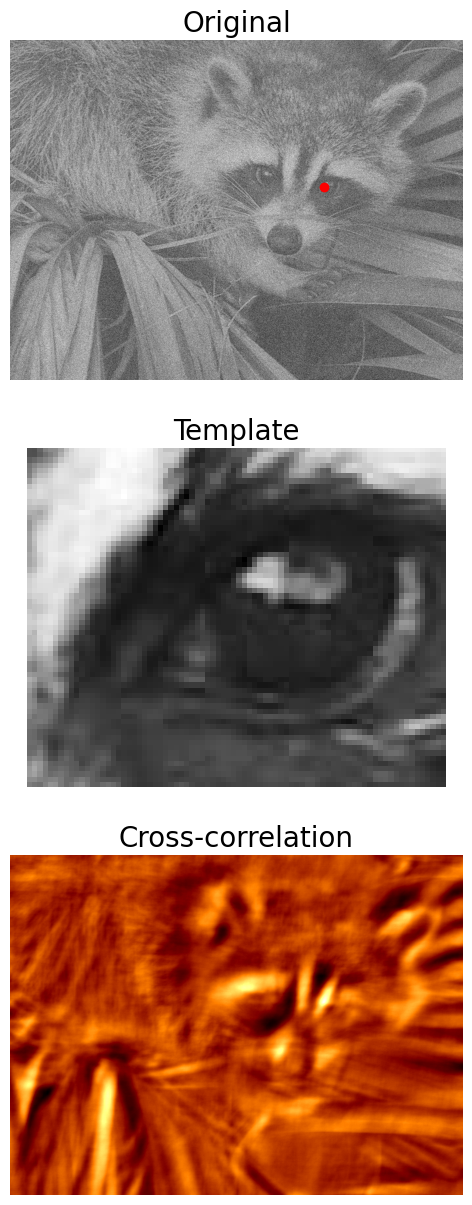

In [10]:
face_image = misc.face(gray=True) - misc.face(gray=True).mean()
template_image = np.copy(face_image[300:365, 670:750])
template_image -= template_image.mean()
face_image = face_image + np.random.randn(*face_image.shape) * 50 
correlation = signal.correlate2d(face_image, template_image, boundary='symm', mode='same')
y, x = np.unravel_index(np.argmax(correlation), correlation.shape)
fig, (ax_original, ax_template, ax_correlation) = plt.subplots(3, 1, figsize=(6, 15))
ax_original.imshow(face_image, cmap='gray')
ax_original.set_title('Original', size=20)
ax_original.set_axis_off()
ax_template.imshow(template_image, cmap='gray')
ax_template.set_title('Template', size=20)
ax_template.set_axis_off()
ax_correlation.imshow(correlation, cmap='afmhot')
ax_correlation.set_title('Cross-correlation', size=20)
ax_correlation.set_axis_off()
ax_original.plot(x, y, 'ro')
fig.show()
